In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt


In [2]:
raster_path = "T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(raster_path, dirver='JP2OpenJPEG') as src:
    raster_img = src.read()
    raster_meta = src.meta

In [3]:
print(raster_img.shape)

(3, 10980, 10980)


In [4]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

In [5]:
raster_img = reshape_as_image(raster_img)

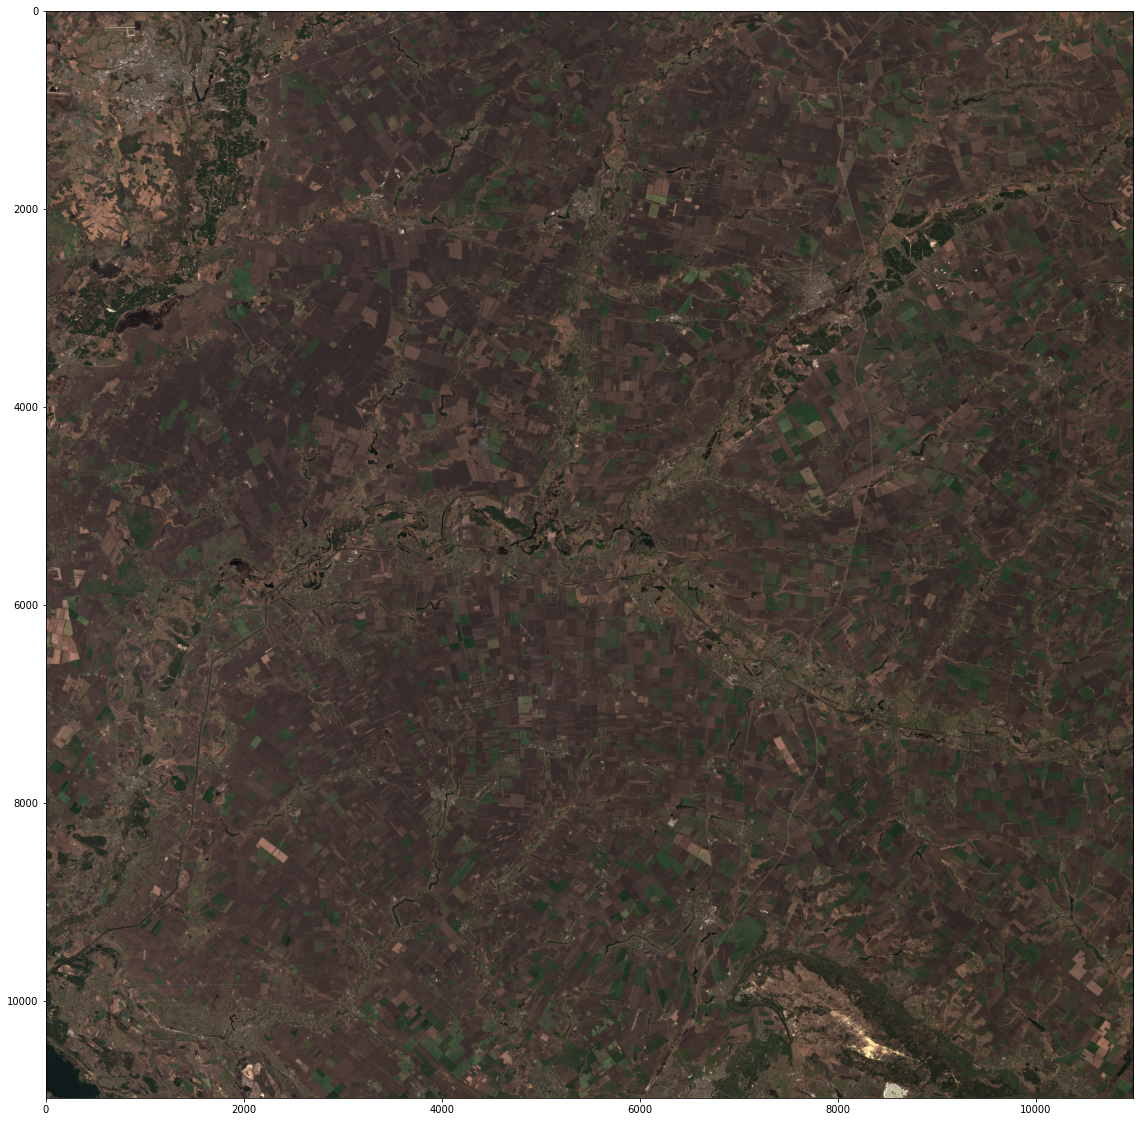

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(raster_img)

In [7]:
train_df = gpd.read_file('masks/Masks_T36UXV_20190427.shp')
print(len(train_df))
train_df

936


,id,Data,Code,Descriptio,Comments,Image,geometry
0,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,None,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."
...,...,...,...,...,...,...,...
931,None,None,1.0,color+ structure,None,T36UXV_20190427T083601,"POLYGON ((35.60033 49.04547, 35.60011 49.04496..."
932,None,None,1.0,color+ structure,None,T36UXV_20190427T083601,"POLYGON ((35.59042 49.04165, 35.59127 49.04155..."
933,None,None,1.0,color+ structure,None,T36UXV_20190427T083601,"POLYGON ((35.60754 49.05593, 35.60796 49.05600..."
934,None,None,1.0,color+ structure,None,T36UXV_20190427T083601,"POLYGON ((35.52378 48.76951, 35.52332 48.76918..."


In [8]:
train_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          0 non-null      object  
 1   Data        0 non-null      object  
 2   Code        340 non-null    float64 
 3   Descriptio  335 non-null    object  
 4   Comments    17 non-null     object  
 5   Image       325 non-null    object  
 6   geometry    935 non-null    geometry
dtypes: float64(1), geometry(1), object(5)
memory usage: 51.3+ KB


In [9]:
# Id and Data fields all consist of None. Field "Image" has no information value since we haven't got that one

In [10]:
train_df = train_df.drop(['id', 'Data'], axis=1)

In [11]:
train_df = train_df.drop(train_df[train_df['geometry'].isna()].index, axis=0)

In [12]:
# inspecting for unique values 

for i in train_df.columns:
    print(f'\nColumn: {i}')
    print(train_df[i].unique())
    


Column: Code
[ 2.  1.  5.  3.  9. nan  4.]

Column: Descriptio
['branch of tree' 'color+ feathers' 'brahch of tree'
 'color+ feathers + branch' 'color + feathers' 'branch + color+ feathers'
 'small branch' '???' None 'color+ structure' 'color (map NGO)'
 'color (opodz)' 'small tree']

Column: Comments
[None 'It`s difficult to diagnose the type' 'Problem with mosaic (shares)'
 'M.b. problem with shares' 'm.b. hard detection' 'opodz soil (NGO)']

Column: Image
['T36UXV_20190427T083601' None]

Column: geometry
<GeometryArray>
 ...
Length: 935, dtype: geometry


In [13]:
# 1. Spoted mistakes or equal values at 'Descriptio' column
train_df['Descriptio'] = train_df['Descriptio'].replace({'brahch of tree': 'branch of tree',
                                                         'color+ feathers': 'color + feathers',
                                                         'color+ feathers + branch': 'color + feathers + branch',
                                                         'branch + color+ feathers': 'color + feathers + branch'})

In [14]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 935 files


In [15]:
# assigning crs
train_df.crs = {'init': 'epsg:4200'} # 4200 - 434 files failed
                                     # 2496 - doesn't work

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

/home/matr1x/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
# as all the masks we have are examples of soil errosion, we shouldn't neglect data with 'Code' = None
train_df['Code'] = train_df['Code'].fillna(0)

In [17]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "train_imgs/"
os.makedirs(outfolder, exist_ok=True)
failed = []
i = 0
norm = [] 
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['Code']) + str(num) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
        norm.append(num)
        i+=1
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))
print(i)

Rasterio failed to mask 434 files
501


In [18]:
norm_df = pd.DataFrame(train_df, index=norm)
for i in sorted(norm_df['Code'].unique()):
    print(f'Code: {i} count = {norm_df[norm_df["Code"] == i].shape[0]}')


Code: 0.0 count = 410
Code: 1.0 count = 36
Code: 2.0 count = 42
Code: 3.0 count = 4
Code: 5.0 count = 7
Code: 9.0 count = 2


In [19]:
train_df_failed = pd.DataFrame(train_df, index=failed)
train_df_failed

,Code,Descriptio,Comments,Image,geometry
12,1.0,color + feathers,None,T36UXV_20190427T083601,"POLYGON ((683993.669 5500233.801, 683953.809 5..."
13,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((682145.640 5500877.583, 682182.462 5..."
14,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((682013.324 5500922.470, 682040.545 5..."
43,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((667870.295 5501374.450, 667947.830 5..."
44,9.0,???,Problem with mosaic (shares),T36UXV_20190427T083601,"POLYGON ((653683.140 5500542.966, 653721.415 5..."
...,...,...,...,...,...
926,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((726990.911 5489818.265, 727025.820 5..."
927,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((727780.822 5489940.790, 727824.789 5..."
928,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((726377.365 5489625.526, 726423.785 5..."
929,1.0,color+ structure,None,T36UXV_20190427T083601,"POLYGON ((714002.222 5487931.995, 713995.693 5..."


In [20]:
# Used ProjFinder to find the proper 'epsg' of coords and it gives value of 2496, 
# but seems like they (coords) aren't a part of a given image

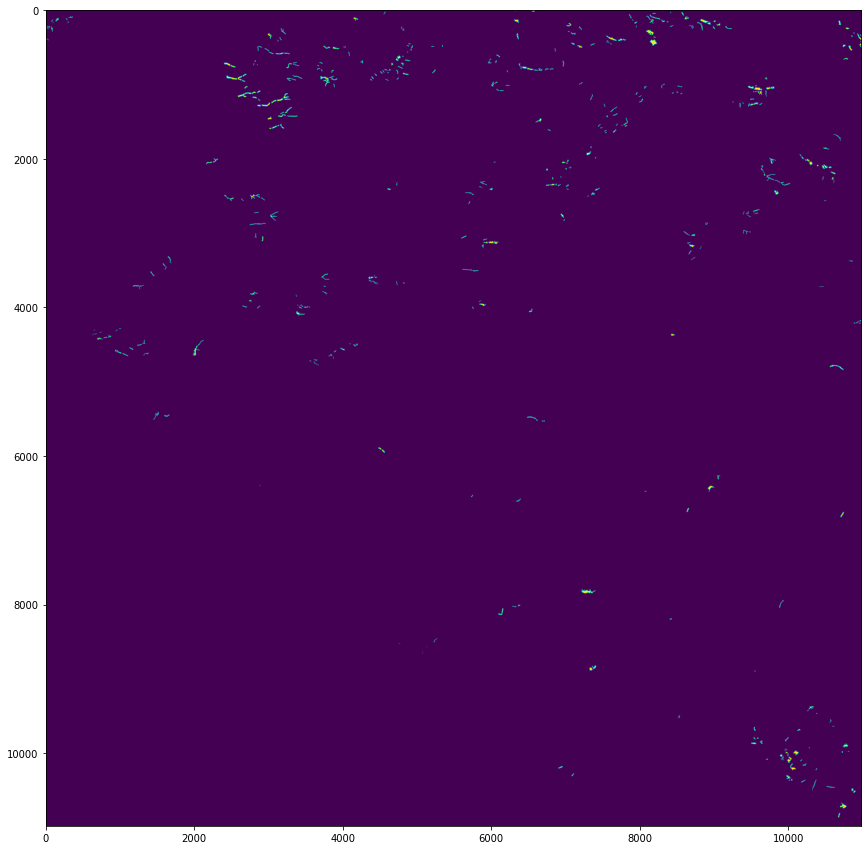

In [21]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for erosion/non-erosion segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

In [98]:
### model

  Based on this paper "https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi597-Tr-7xAhVXhf0HHTAQDUUQFjAMegQIGxAD&url=https%3A%2F%2Fwww.mdpi.com%2F2072-4292%2F12%2F24%2F4063%2Fpdf&usg=AOvVaw3zppkjN0z9lttEE6VYtwIB" we can say that there's been already developed several methods to spot soil erosion problems: "Recent studies have introduced several
new approaches on the model application and scenario-based simulations to predict the impacts of land
use and climate change on soil erosion. A combined approached of LTM (Artificial Neural Networks
algorithm- ANN), SCS-CN model and ARUMA has been applied to soil erosion assessment by Rizeel et
al.[60] Arambarani et al.[61] have employed AHP and multi-criteria decision-making approach in the
GIS environment to investigate the erosion-prone areas. LTM together ANN with and USLE models
have been used to predict soil erosion and land cover dynamics" (p.6, 2.1.3. Conceptual Methods). 


  
  Also one more important thing to mention is that due to climatic changes soil errosion heavily depends on rainfall: "It further reveals less research attention on the spatial and temporal pattern of soil erosion along with rainfall characteristics such as rainfall amount, rainfall intensity, rainfall depth, erosivity and the number of rainy days with present climate variation. The relationships between rainfall variation and potential soil erosion hazards in different climatic regions are still far from clear in the literature"(p.16). 
  
  

That's why it's crutial to monitor climate and weather changes in tender regions and develop a model that predicts potential damage in order to prevent occurrence of soil erosion.

This paper is the most recent (published 11 December 2020)